In [5]:
from copy import deepcopy
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from skimage.draw import line, disk
from scipy.optimize import minimize
from calorimeter import calo_importer
import scipy.io
import cvxpy as cp
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from math import atan2, acos
from sklearn.linear_model import LinearRegression

In [ ]:
pip install scikit-learn

In [2]:
import scipy.io
calorimeter_response_protons = scipy.io.loadmat("calorimeter_response.mat")
secondary_protons = scipy.io.loadmat("secondary.mat")
calorimeter_response_antiprotons = scipy.io.loadmat("calorimeter_response_antiprotons.mat")
secondary_antiprotons = scipy.io.loadmat("secondary_antiprotons.mat")

In [7]:
data = deepcopy(calorimeter_response_protons)

In [8]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue May 21 14:33:20 2024',
 '__version__': '1.0',
 '__globals__': [],
 'E_0': array([[1745.39, 2859.57, 1433.08, ..., 4222.97, 6916.87, 6589.18]]),
 'X_0': array([[-72.9942, -37.1207, -69.118 , ...,  47.0039, -61.3038, -20.493 ]]),
 'Y_0': array([[ 11.0633, -85.0243, -33.8059, ...,  22.3615,  62.9135,  47.3031]]),
 'theta_0': array([[0.503032 , 0.56611  , 0.0662649, ..., 0.768048 , 0.606821 ,
         0.0842612]]),
 'phi_0': array([[0.17943, 4.36732, 2.73976, ..., 3.22291, 3.3012 , 3.24898]]),
 'Z_end': array([[139.821  ,   3.40819, 213.576  , ..., 101.     , 125.106  ,
         213.576  ]]),
 'last_process': array(['protonInelastic', 'protonInelastic', 'Transportation ', ...,
        'protonInelastic', 'Transportation ', 'Transportation '],
       dtype='<U15'),
 'event_ID': array([[   0.,    0.,    0., ..., 9999., 9999., 9999.]]),
 'layer': array([[ 0.,  1.,  2., ..., 41., 42., 43.]]),
 'index_along_x': array([[19., 20

In [9]:
X = data['X_0']
shape_X = X.shape
shape_X


(1, 10000)

In [10]:
#np.set_printoptions(threshold=np.inf)

last_proc= data['last_process']
last_proc[12]

'protonInelastic'

In [11]:
plane_yz_np_data = np.array(data['X_0'])
plane_xz_np_data = np.array(data['Y_0'])
plane_yz_np_data

array([[-72.9942, -37.1207, -69.118 , ...,  47.0039, -61.3038, -20.493 ]])

In [12]:
secondary_protons

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue May 21 14:33:22 2024',
 '__version__': '1.0',
 '__globals__': [],
 'secondary': array([[array([[ 1.00000e+00,  2.21200e+03, -7.29942e+01,  1.10633e+01,
                 -1.00000e+00,  1.74539e+03],
                [ 1.00000e+00,  2.21200e+03, -7.24528e+01,  1.11615e+01,
                  0.00000e+00,  1.74539e+03],
                [ 1.00000e+00,  2.21200e+03, -7.22470e+01,  1.11989e+01,
                  3.80000e-01,  1.74523e+03],
                ...,
                [ 2.00000e+00,  1.10000e+01, -5.99821e+01,  1.37972e+01,
                  2.41625e+01,  1.38636e-01],
                [ 2.00000e+00,  1.10000e+01, -5.99977e+01,  1.38232e+01,
                  2.41018e+01,  9.32497e-02],
                [ 2.00000e+00,  1.10000e+01, -6.00138e+01,  1.38341e+01,
                  2.40692e+01,  0.00000e+00]])                          ,
         array([[ 1.00000e+00,  2.21200e+03, -3.71207e+01, -8.50243e+01,
               

In [3]:
sys.path.append(r'/Users/pavelnehaenko/Downloads/pamela-master/src')  

In [6]:
fnum = 1
dpath = '/Users/pavelnehaenko/Desktop/me/kursach/simulation' 
siminfofile = 'protons/SimInfo/SimInfo_pr_0p1_1500_rig_F0p8_10000000_1.mat'.format(fnum)
siminfo_data = scipy.io.loadmat(os.path.join(dpath, siminfofile), variable_names=['caloplaneint', 'fTHETA', 'fPHI'])

In [13]:
siminfo_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Dec 26 08:55:45 2021',
 '__version__': '1.0',
 '__globals__': [],
 'caloplaneint': array([[ 9],
        [44],
        [44],
        ...,
        [31],
        [44],
        [44]], dtype=uint8),
 'fPHI': array([[2.88771],
        [2.04032],
        [5.38962],
        ...,
        [5.56478],
        [1.8101 ],
        [2.51839]]),
 'fTHETA': array([[0.10897  ],
        [0.0970378],
        [0.107277 ],
        ...,
        [0.270176 ],
        [0.166132 ],
        [0.272713 ]])}

In [14]:
nn = range(1, 1001)
dfile = 'protons/CaloStrip/CaloStrip_pr_0p1_1500_rig_F0p8_10000000_1.mat'.format(fnum)
calo_events = calo_importer.import_data(os.path.join(dpath, dfile), events=nn)

.mat file loaded


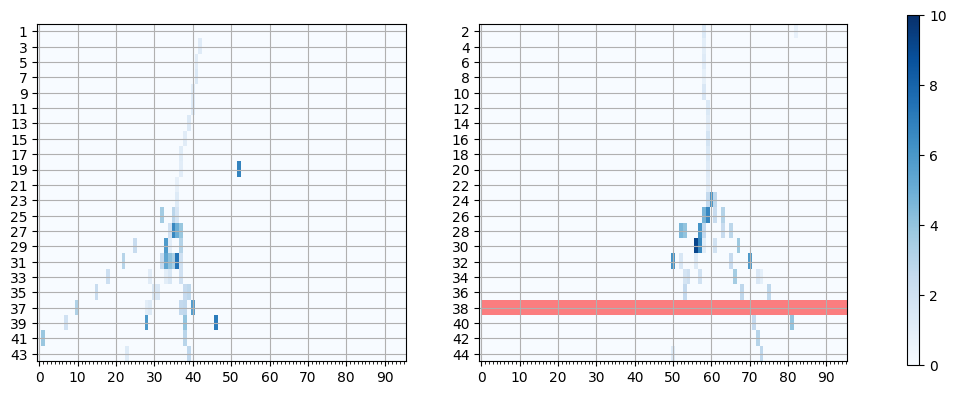

In [15]:
# Изображение проекции калориметра
calo_events[6].plot()

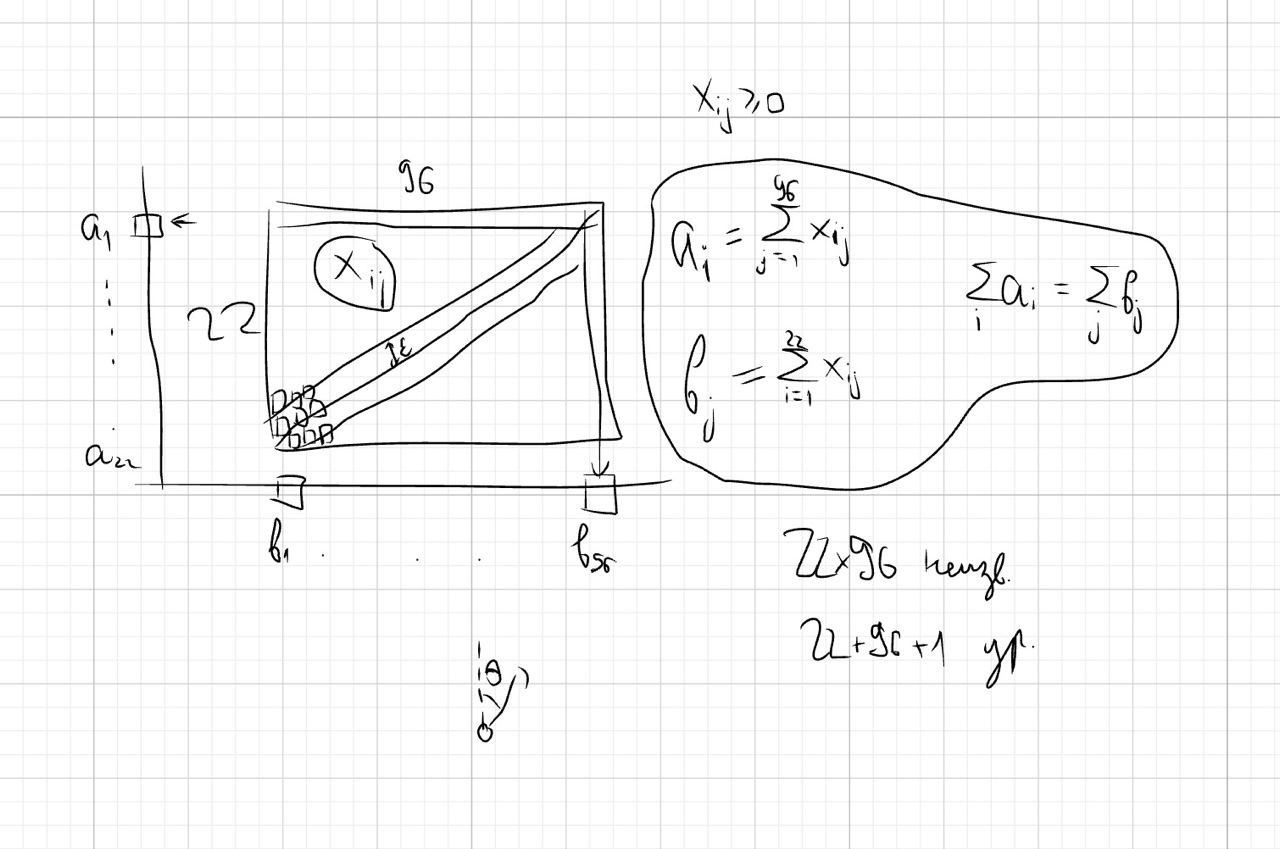

In [16]:
Image('1.jpg')

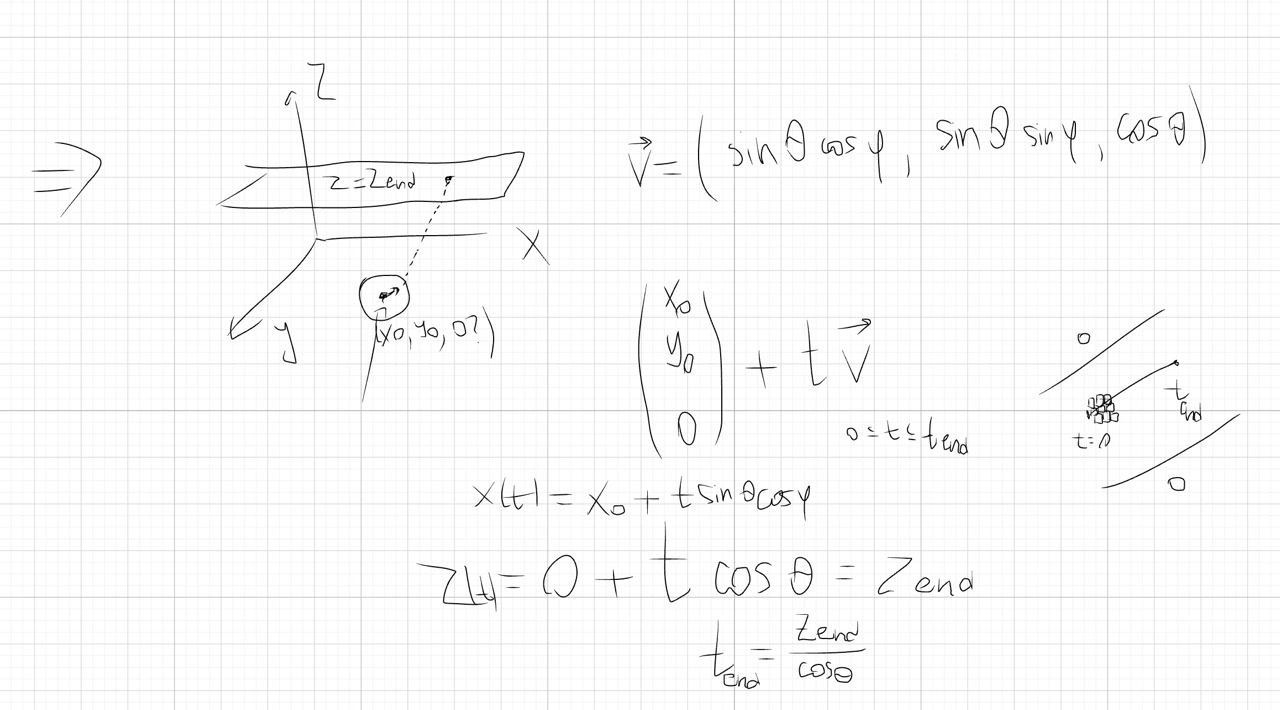

In [17]:
Image('2.jpg')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


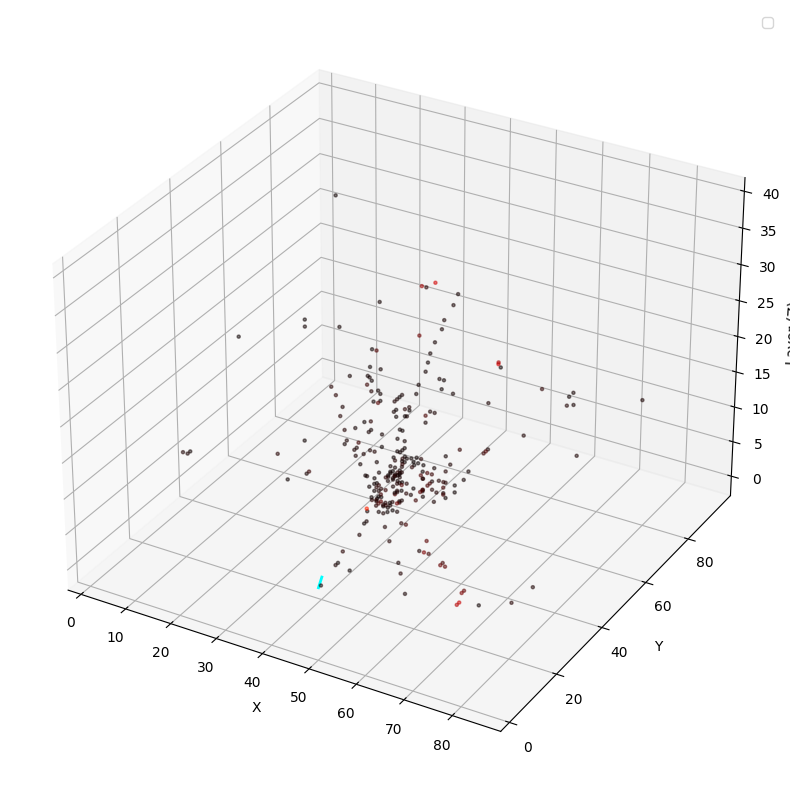

In [3]:
def load_mat_data(mat_path):
    """Загружает данные из .mat или .npy файла с калориметра"""
    if mat_path.endswith(".npy"):
        return np.load(mat_path, allow_pickle=True).item()
    elif mat_path.endswith(".mat"):
        raw = scipy.io.loadmat(mat_path)
        return {k: v.squeeze() for k, v in raw.items() if not k.startswith("__")}
    else:
        raise ValueError("Unsupported file format")

def visualize_event(calo_data, event_id=0, scale=2.56, z_step=6.19, z_size=44, y_size=96, x_size=96):
    """Создает объем энерговыделения и визуализирует его вместе с теоретическим треком"""
    volume = np.zeros((z_size, y_size, x_size), dtype=np.float32)

    mask = calo_data['event_ID'] == event_id
    x_idx = calo_data['index_along_x'][mask].astype(int)
    y_idx = calo_data['index_along_y'][mask].astype(int)
    z_idx = calo_data['layer'][mask].astype(int)
    energy = calo_data['energy_release'][mask]

    for x, y, z, e in zip(x_idx, y_idx, z_idx, energy):
        if 0 <= x < x_size and 0 <= y < y_size and 0 <= z < z_size:
            volume[z, y, x] += e

    x0 = calo_data["X_0"][event_id]
    y0 = calo_data["Y_0"][event_id]
    phi = calo_data["phi_0"][event_id]
    theta = calo_data["theta_0"][event_id]
    zend = calo_data["Z_end"][event_id]

    x0_idx = int(np.clip(x0 / scale + x_size // 2, 0, x_size - 1))
    y0_idx = int(np.clip(y0 / scale + y_size // 2, 0, y_size - 1))

    t_end = zend / z_step
    t_vals = np.linspace(0, t_end, 100)
    vx = np.sin(theta) * np.cos(phi)
    vy = np.sin(theta) * np.sin(phi)
    vz = np.cos(theta)

    track_x = x0_idx + t_vals * vx / scale
    track_y = y0_idx + t_vals * vy / scale
    track_z = t_vals * vz

    mask = (track_x >= 0) & (track_x < x_size) & (track_y >= 0) & (track_y < y_size) & (track_z >= 0) & (track_z < z_size)
    track_x, track_y, track_z = track_x[mask], track_y[mask], track_z[mask]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    z_, y_, x_ = np.nonzero(volume > 0.1)
    e_ = volume[z_, y_, x_]
    ax.scatter(x_, y_, z_, c=e_, cmap='hot', s=5, alpha=0.5)
    ax.plot(track_x, track_y, track_z, color='cyan', linewidth=2)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Layer (Z)")
    #ax.set_title(f"Event ID: {event_id} — 3D Track and Energy Hits")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Загрузка и визуализация из файла
file_path = "calorimeter_response.npy"
calo_data = load_mat_data(file_path)
visualize_event(calo_data, event_id=3)


| Объект | Размерность        | Значение                          |
| ------ | ------------------ | --------------------------------- |
| `x`    | 405 504 = 44×96×96 | Искомое векторное распределение   |
| `b`    | 8 448 = 44×(96+96) | Вектор наблюдаемых проекций       |
| `A`    | (8448, 405504)     | Разреженная матрица проецирования |


In [8]:
import numpy as np
import scipy.optimize
from scipy.sparse import lil_matrix

# Настройки объёма
Z, Y, X = 44, 96, 96
V = Z * Y * X  # размерность x
B = Z * (X + Y)  # размерность b

def build_projection_matrix(z_size=44, y_size=96, x_size=96):
    """
    Строит разреженную матрицу A: Ax = b,
    где b — вектор из проекций (по X и по Y).
    Сначала идут строки проекции по X (по оси i), затем по Y (по оси j).
    """
    A = lil_matrix((z_size * (x_size + y_size), z_size * y_size * x_size), dtype=np.float32)

    row = 0
    for z in range(z_size):
        # проекции по X (сумма по i → фиксированы j, k)
        for y in range(y_size):
            for x in range(x_size):
                col = z * y_size * x_size + y * x_size + x
                A[row, col] = 1.0
            row += 1
        # проекции по Y (сумма по j → фиксированы i, k)
        for x in range(x_size):
            for y in range(y_size):
                col = z * y_size * x_size + y * x_size + x
                A[row, col] = 1.0
            row += 1
    return A.tocsr()

# Получим реальные проекции
def get_volume_for_event(calo_data, event_id=0):
    mask = calo_data['event_ID'] == event_id
    x = calo_data['index_along_x'][mask].astype(int)
    y = calo_data['index_along_y'][mask].astype(int)
    z = calo_data['layer'][mask].astype(int)
    e = calo_data['energy_release'][mask]

    volume = np.zeros((Z, Y, X), dtype=np.float32)
    for xi, yi, zi, ei in zip(x, y, z, e):
        if 0 <= xi < X and 0 <= yi < Y and 0 <= zi < Z:
            volume[zi, yi, xi] += ei
    return volume

def compute_projections(volume):
    proj_x = np.sum(volume, axis=2).reshape(-1)  # (Z, Y) → flatten
    proj_y = np.sum(volume, axis=1).reshape(-1)  # (Z, X) → flatten
    return np.concatenate([proj_x, proj_y])  # (Z*(Y+X),)

# Загрузка данных
calo_data = np.load("calorimeter_response.npy", allow_pickle=True).item()
volume = get_volume_for_event(calo_data, event_id=0)
b = compute_projections(volume)
A = build_projection_matrix()

# Проверка размеров
A.shape, b.shape


((8448, 405504), (8448,))

event 0: max_b=0.000e+00, used=0 → weak
event 1: max_b=7.136e+00, used=21 → OK
event 2: max_b=0.000e+00, used=0 → weak
event 3: max_b=1.313e-02, used=2 → weak
event 4: max_b=0.000e+00, used=0 → weak
event 5: max_b=0.000e+00, used=0 → weak
event 6: max_b=0.000e+00, used=0 → weak
event 7: max_b=0.000e+00, used=0 → weak
event 8: max_b=0.000e+00, used=0 → weak
event 9: max_b=0.000e+00, used=0 → weak
event 10: max_b=0.000e+00, used=0 → weak
event 11: max_b=0.000e+00, used=0 → weak
event 12: max_b=0.000e+00, used=0 → weak
event 13: max_b=0.000e+00, used=0 → weak
event 14: max_b=0.000e+00, used=0 → weak
event 15: max_b=0.000e+00, used=0 → weak
event 16: max_b=0.000e+00, used=0 → weak
event 17: max_b=0.000e+00, used=0 → weak
event 18: max_b=0.000e+00, used=0 → weak
event 19: max_b=1.305e-01, used=17 → OK
event 20: max_b=0.000e+00, used=0 → weak
event 21: max_b=0.000e+00, used=0 → weak
event 22: max_b=5.677e-01, used=15 → OK
event 23: max_b=3.918e+00, used=22 → OK
event 24: max_b=0.000e+00, use

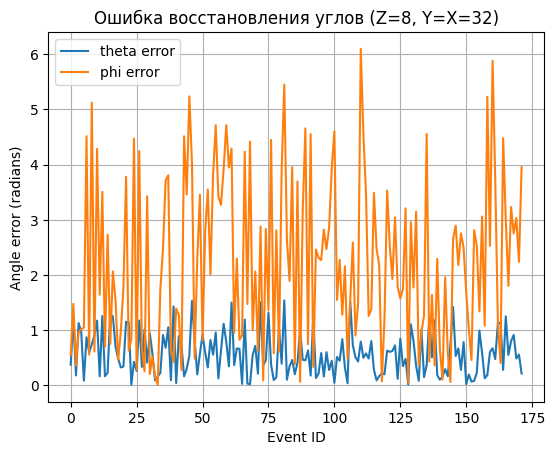

130


In [23]:

# Восстановление треков из проекций с регуляризацией (батч + логирование)
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix
from math import atan2, acos
from sklearn.linear_model import LinearRegression

# Загрузка
calo_data = np.load("calorimeter_response.npy", allow_pickle=True).item()

def get_volume_for_event(calo_data, event_id=0, z_size=44, y_size=96, x_size=96):
    mask = calo_data['event_ID'] == event_id
    x = calo_data['index_along_x'][mask].astype(int)
    y = calo_data['index_along_y'][mask].astype(int)
    z = calo_data['layer'][mask].astype(int)
    e = calo_data['energy_release'][mask]
    volume = np.zeros((z_size, y_size, x_size), dtype=np.float32)
    for xi, yi, zi, ei in zip(x, y, z, e):
        if 0 <= xi < x_size and 0 <= yi < y_size and 0 <= zi < z_size:
            volume[zi, yi, xi] += ei
    return volume

def compute_projections(volume):
    return np.concatenate([np.sum(volume, axis=2).reshape(-1), np.sum(volume, axis=1).reshape(-1)])

def build_projection_matrix(Z, Y, X):
    A = lil_matrix((Z * (Y + X), Z * Y * X), dtype=np.float32)
    row = 0
    for z in range(Z):
        for y in range(Y):
            for x in range(X):
                col = z * Y * X + y * X + x
                A[row, col] = 1.0
            row += 1
        for x in range(X):
            for y in range(Y):
                col = z * Y * X + y * X + x
                A[row, col] = 1.0
            row += 1
    return A.tocsr()

def smoothness_matrix(Z, Y, X):
    rows, cols, data = [], [], []
    row_id = 0
    for z in range(Z - 1):
        for y in range(Y):
            for x_ in range(X):
                idx1 = z * Y * X + y * X + x_
                idx2 = (z + 1) * Y * X + y * X + x_
                rows += [row_id, row_id]
                cols += [idx1, idx2]
                data += [-1.0, 1.0]
                row_id += 1
    return csr_matrix((data, (rows, cols)), shape=(row_id, Z * Y * X))

def compute_track_angles(volume):
    Z, Y, X = volume.shape
    z_vals, x_centers, y_centers = [], [], []
    for z in range(Z):
        layer = volume[z]
        total = np.sum(layer)
        if total > 1e-6:
            y_coords, x_coords = np.indices(layer.shape)
            x_center = np.sum(x_coords * layer) / total
            y_center = np.sum(y_coords * layer) / total
            z_vals.append(z)
            x_centers.append(x_center)
            y_centers.append(y_center)
    z_vals = np.array(z_vals).reshape(-1, 1)
    reg_x = LinearRegression().fit(z_vals, x_centers)
    reg_y = LinearRegression().fit(z_vals, y_centers)
    dx, dy, dz = reg_x.coef_[0], reg_y.coef_[0], 1.0
    norm = np.sqrt(dx**2 + dy**2 + dz**2)
    return acos(dz / norm), atan2(dy, dx)

def get_true_angles(calo_data, event_id):
    theta = calo_data["theta_0"][event_id]
    phi = calo_data["phi_0"][event_id]
    vx = np.sin(theta) * np.cos(phi)
    vy = np.sin(theta) * np.sin(phi)
    vz = np.cos(theta)
    norm = np.sqrt(vx**2 + vy**2 + vz**2)
    return np.arccos(vz / norm), np.arctan2(vy, vx)

# === Параметры ===
Z, Y, X = 8, 32, 32
num_events = 10
lambda_reg = 0.1
D = smoothness_matrix(Z, Y, X)

theta_errors = []
phi_errors = []
cnt = 0

for event_id in range(1000):
    volume = get_volume_for_event(calo_data, event_id, Z, Y, X)
    b = compute_projections(volume)
    A = build_projection_matrix(Z, Y, X)

    mask = np.abs(b) > 1e-5
    max_b = np.max(b)
    used = np.count_nonzero(mask)
    if max_b > 0.1 and used > 5:
        status = "OK" 
        cnt += 1
    else:
        status = "weak"
    print(f"event {event_id}: max_b={max_b:.3e}, used={used} → {status}")

    if used == 0:
        continue

    A_sparse = csr_matrix(A[mask])
    b_clean = b[mask]

    x = cp.Variable(A_sparse.shape[1], nonneg=True)
    objective = cp.Minimize(cp.sum_squares(A_sparse @ x - b_clean) + lambda_reg * cp.sum_squares(D @ x))
    problem = cp.Problem(objective)
    problem.solve(solver=cp.OSQP, verbose=False)

    volume_hat = x.value.reshape((Z, Y, X))
    theta_hat, phi_hat = compute_track_angles(volume_hat)
    theta_true, phi_true = get_true_angles(calo_data, event_id)

    theta_errors.append(abs(theta_hat - theta_true))
    phi_errors.append(abs(phi_hat - phi_true))


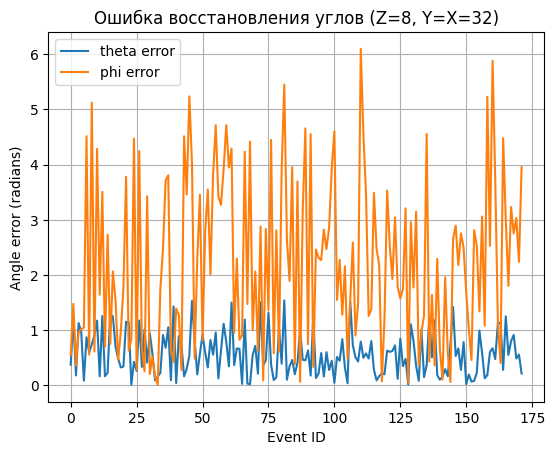

130


In [24]:
# === Визуализация ===
plt.plot(range(len(theta_errors)), theta_errors, label="theta error")
plt.plot(range(len(phi_errors)), phi_errors, label="phi error")
plt.xlabel("Event ID")
plt.ylabel("Angle error (radians)")
plt.legend()
plt.grid()
plt.title("Ошибка восстановления углов (Z=8, Y=X=32)")
plt.show()
print(cnt)

In [37]:
import cvxpy as cp
from scipy.sparse import csr_matrix

# Построение TV-матрицы
def build_tv_matrix(Z, Y, X):
    rows, cols, data = [], [], []
    row_id = 0
    def add_diff(i, j):
        nonlocal row_id, rows, cols, data
        rows += [row_id, row_id]
        cols += [i, j]
        data += [-1.0, 1.0]
        row_id += 1
    for z in range(Z):
        for y in range(Y):
            for x in range(X):
                idx = z * Y * X + y * X + x
                if x + 1 < X: add_diff(idx, idx + 1)
                if y + 1 < Y: add_diff(idx, idx + X)
                if z + 1 < Z: add_diff(idx, idx + Y * X)
    return csr_matrix((data, (rows, cols)), shape=(row_id, Z * Y * X))

# === Оптимизация с TV-регуляризацией ===
Z, Y, X = 8, 32, 32
lambda_tv = 0.01
D_tv = build_tv_matrix(Z, Y, X)
event_id = 961
volume = get_volume_for_event(calo_data, event_id, Z, Y, X)
b = compute_projections(volume)
A = build_projection_matrix(Z, Y, X)
mask = np.abs(b) > 1e-5

if np.sum(mask) > 0:
    A_sparse = csr_matrix(A[mask])
    b_clean = b[mask]
    x = cp.Variable(A_sparse.shape[1], nonneg=True)
    objective = cp.Minimize(cp.sum_squares(A_sparse @ x - b_clean) + lambda_tv * cp.norm1(D_tv @ x))
    problem = cp.Problem(objective)
    problem.solve(solver=cp.OSQP, verbose=True)
    volume_tv = x.value.reshape((Z, Y, X))
    print("✔ Solver status:", problem.status)
    print("📉 Objective value:", problem.value)

    if x.value is not None:
        print("✅ Solution vector shape:", x.shape)
        print("📦 Volume shape:", (Z, Y, X))
        print("🔍 Max value in solution:", np.max(x.value))
    else:
        print("❌ No solution found.")
    
else:
    print(1)
    volume_tv = None



                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 25 08:50:18 PM: Your problem has 8192 variables, 0 constraints, and 0 parameters.
(CVXPY) May 25 08:50:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 25 08:50:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 25 08:50:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 25 08:50:18 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 25 08:50:18 PM: Compiling problem (target solver=OSQP).
(C

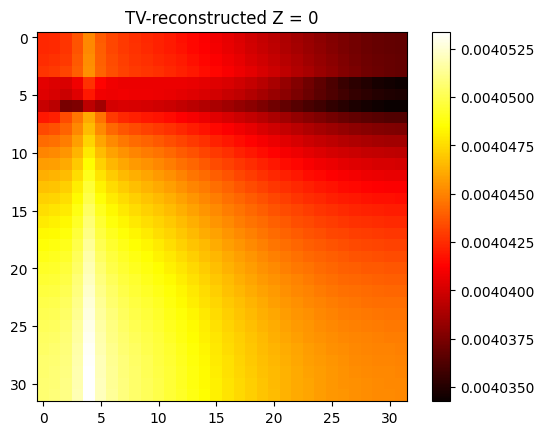

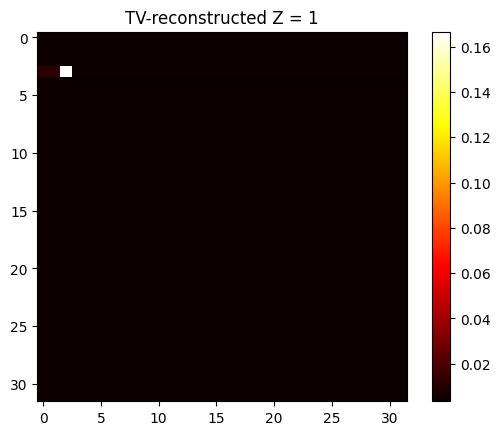

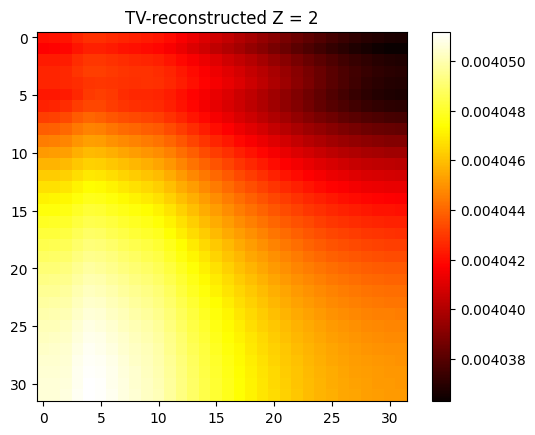

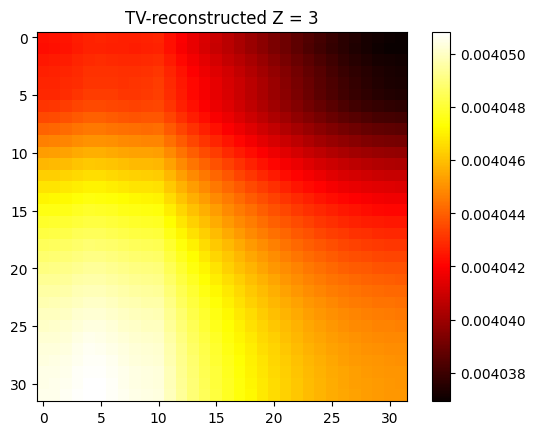

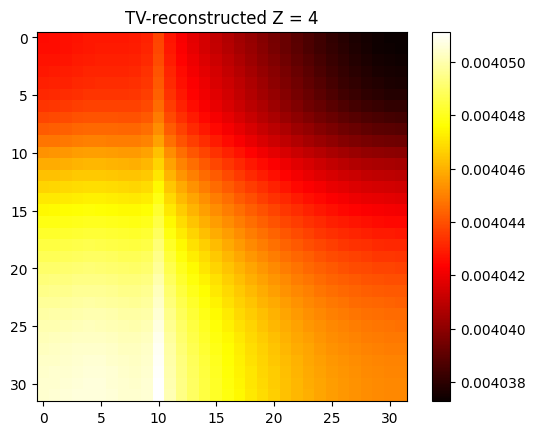

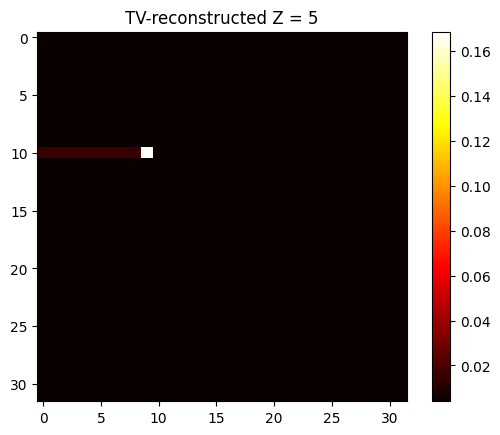

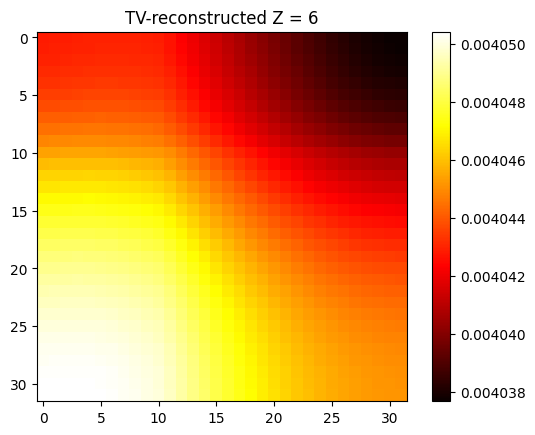

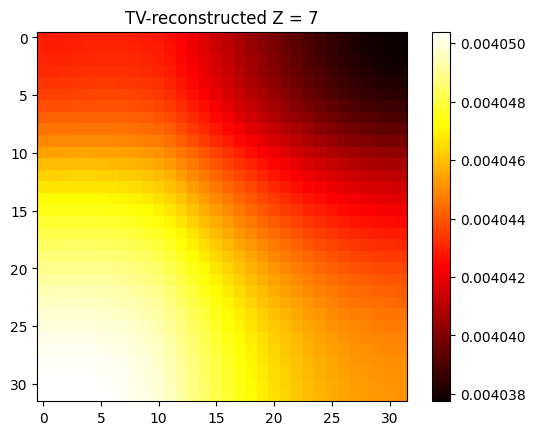

In [38]:
for z in range(Z):
    plt.imshow(volume_tv[z], cmap="hot")
    plt.title(f"TV-reconstructed Z = {z}")
    plt.colorbar()
    plt.show()

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 25 09:36:22 PM: Your problem has 8192 variables, 0 constraints, and 0 parameters.
(CVXPY) May 25 09:36:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 25 09:36:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 25 09:36:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 25 09:36:22 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 25 09:36:22 PM: Compiling problem (target solver=OSQP).
(C

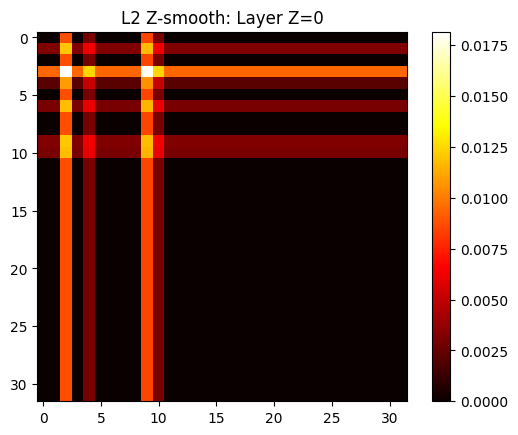

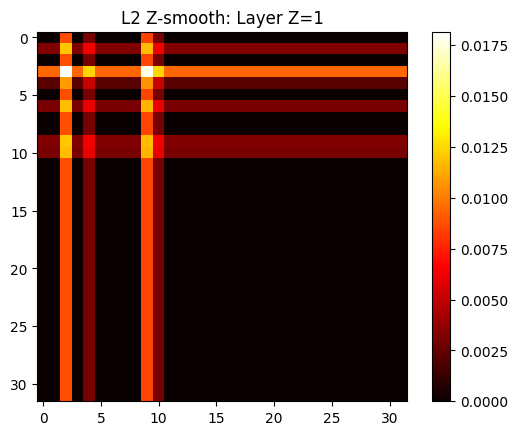

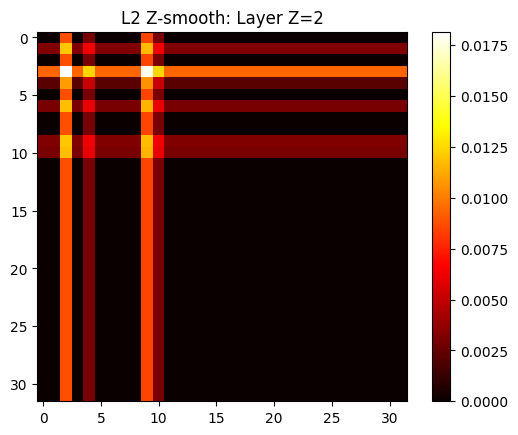

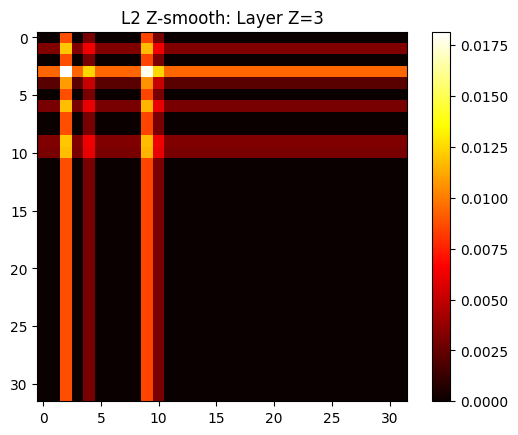

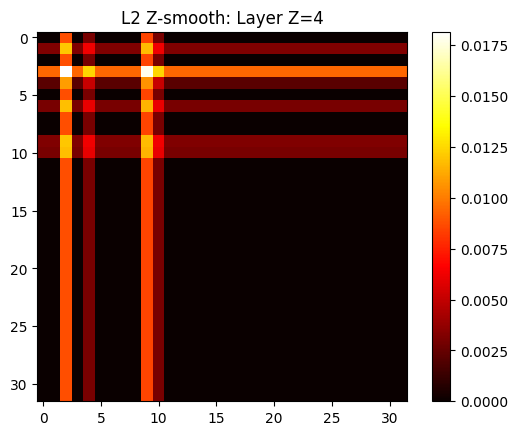

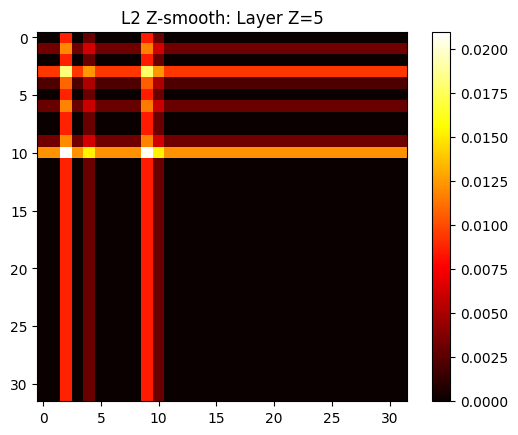

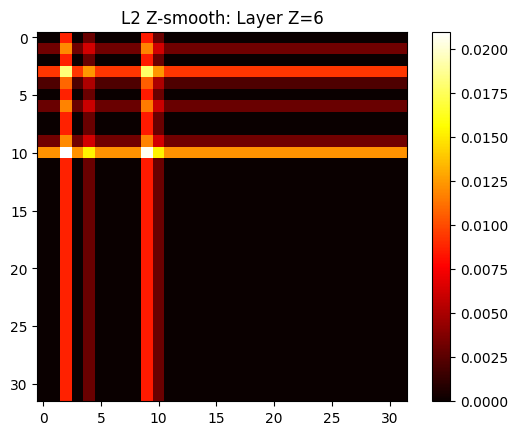

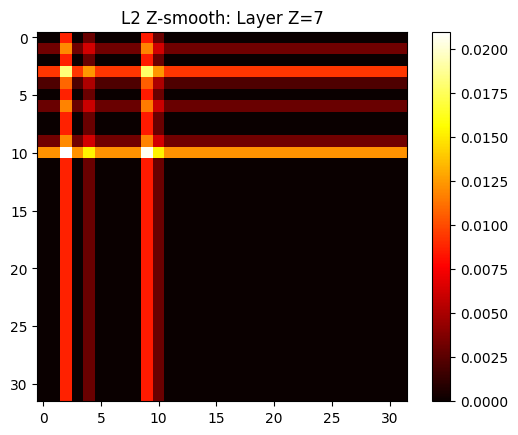

In [40]:
# Построение матрицы сглаживания по оси Z
from scipy.sparse import csr_matrix

def build_z_smoothness_matrix(Z, Y, X):
    rows, cols, data = [], [], []
    row_id = 0
    for z in range(Z - 1):
        for y in range(Y):
            for x in range(X):
                idx1 = z * Y * X + y * X + x
                idx2 = (z + 1) * Y * X + y * X + x
                rows += [row_id, row_id]
                cols += [idx1, idx2]
                data += [-1.0, 1.0]
                row_id += 1
    return csr_matrix((data, (rows, cols)), shape=(row_id, Z * Y * X))

# === Параметры ===
lambda_l2 = 0.1  # сила регуляризации
D_z = build_z_smoothness_matrix(Z, Y, X)

# === Оптимизация ===
x_l2 = cp.Variable(A_sparse.shape[1], nonneg=True)
objective_l2 = cp.Minimize(cp.sum_squares(A_sparse @ x_l2 - b_clean) + lambda_l2 * cp.sum_squares(D_z @ x_l2))
problem_l2 = cp.Problem(objective_l2)
problem_l2.solve(solver=cp.OSQP, verbose=True)

volume_hat = x_l2.value.reshape((Z, Y, X))

# === Отрисовка ===
import matplotlib.pyplot as plt
for z in range(Z):
    plt.imshow(volume_hat[z], cmap="hot")
    plt.title(f"L2 Z-smooth: Layer Z={z}")
    plt.colorbar()
    plt.show()


In [42]:
from scipy.sparse import csr_matrix

def build_tv_matrix(Z, Y, X):
    rows, cols, data = [], [], []
    row_id = 0

    def add_diff(i, j):
        nonlocal row_id
        rows.append(row_id)
        cols.append(i)
        data.append(-1.0)
        rows.append(row_id)
        cols.append(j)
        data.append(1.0)
        row_id += 1

    for z in range(Z):
        for y in range(Y):
            for x in range(X):
                idx = z * Y * X + y * X + x
                if x + 1 < X: add_diff(idx, idx + 1)
                if y + 1 < Y: add_diff(idx, idx + X)
                if z + 1 < Z: add_diff(idx, idx + Y * X)

    return csr_matrix((data, (rows, cols)), shape=(row_id, Z * Y * X))

# Пример вызова
D_tv = build_tv_matrix(16, 64, 64)
print("D_tv shape:", D_tv.shape)


D_tv shape: (190464, 65536)


In [43]:

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix

# === Настройки ===
Z, Y, X = 44, 96, 96
lambda_tv = 0.01
event_id = 961  # поменяй при необходимости

# === TV-регуляризатор ===
def build_tv_matrix(Z, Y, X):
    rows, cols, data = [], [], []
    row_id = 0
    def add_diff(i, j):
        nonlocal row_id
        rows.append(row_id); cols.append(i); data.append(-1.0)
        rows.append(row_id); cols.append(j); data.append(1.0)
        row_id += 1
    for z in range(Z):
        for y in range(Y):
            for x in range(X):
                idx = z * Y * X + y * X + x
                if x + 1 < X: add_diff(idx, idx + 1)
                if y + 1 < Y: add_diff(idx, idx + X)
                if z + 1 < Z: add_diff(idx, idx + Y * X)
    return csr_matrix((data, (rows, cols)), shape=(row_id, Z * Y * X))

# === Построение A ===
def build_projection_matrix(Z, Y, X):
    A = lil_matrix((Z * (Y + X), Z * Y * X), dtype=np.float32)
    row = 0
    for z in range(Z):
        for y in range(Y):
            for x in range(X):
                A[row, z * Y * X + y * X + x] = 1.0
            row += 1
        for x in range(X):
            for y in range(Y):
                A[row, z * Y * X + y * X + x] = 1.0
            row += 1
    return A.tocsr()

# === Обработка события ===
def get_volume_for_event(calo_data, event_id, Z, Y, X):
    mask = calo_data['event_ID'] == event_id
    x = calo_data['index_along_x'][mask].astype(int)
    y = calo_data['index_along_y'][mask].astype(int)
    z = calo_data['layer'][mask].astype(int)
    e = calo_data['energy_release'][mask]
    volume = np.zeros((Z, Y, X), dtype=np.float32)
    for xi, yi, zi, ei in zip(x, y, z, e):
        if 0 <= xi < X and 0 <= yi < Y and 0 <= zi < Z:
            volume[zi, yi, xi] += ei
    return volume

def compute_projections(volume):
    proj_x = np.sum(volume, axis=2).reshape(-1)
    proj_y = np.sum(volume, axis=1).reshape(-1)
    return np.concatenate([proj_x, proj_y])

# === Основной запуск ===
calo_data = np.load("calorimeter_response.npy", allow_pickle=True).item()
volume = get_volume_for_event(calo_data, event_id, Z, Y, X)
b = compute_projections(volume)
A = build_projection_matrix(Z, Y, X)
mask = np.abs(b) > 1e-5

if np.sum(mask) == 0:
    print("❌ No valid projections for this event.")
    exit()

A_sparse = csr_matrix(A[mask])
b_clean = b[mask]
D_tv = build_tv_matrix(Z, Y, X)

x = cp.Variable(A_sparse.shape[1], nonneg=True)
objective = cp.Minimize(cp.sum_squares(A_sparse @ x - b_clean) + lambda_tv * cp.norm1(D_tv @ x))
problem = cp.Problem(objective)
problem.solve(solver=cp.OSQP, verbose=True)

volume_tv = x.value.reshape((Z, Y, X))

# === Визуализация первых 10 слоёв ===
for z in range(min(10, Z)):
    plt.imshow(volume_tv[z], cmap="hot")
    plt.title(f"TV reconstruction Z = {z}")
    plt.colorbar()
    plt.show()


                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 25 11:13:45 PM: Your problem has 405504 variables, 0 constraints, and 0 parameters.
(CVXPY) May 25 11:13:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 25 11:13:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 25 11:13:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 25 11:13:45 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 25 11:13:45 PM: Compiling problem (target solver=OSQP).


SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
# целевая функция с мягкими ограничениями, где 
# error_c - штраф за отклонение от c_jk
# error_d - штраф за отклонение от d_ik

def objective(x):
    x_ijk = x.reshape((I, J, K))
    error_c = np.sum((np.sum(x_ijk, axis=0) - c_jk) ** 2)  
    error_d = np.sum((np.sum(x_ijk, axis=1) - d_ik) ** 2)  
    return error_c + error_d

In [ ]:
numm = 130
theta_0 = data['theta_0'][0, numm]
phi_0 = data['phi_0'][0, numm]
X_0 = data['X_0'][0, numm]
Y_0 = data['Y_0'][0, numm]
Z_end = data['Z_end'][0, numm]

x_projection = calo_events[numm].x_projection()
y_projection = calo_events[numm].y_projection()

I = 22
J = 22
K = 96 
x0 = np.ones(I * J * K)

c_jk = np.zeros((J, K))  
d_ik = np.zeros((I, K))  

for j in range(J):
    for k in range(K):
        if x_projection[j, k] != 0:
            c_jk[j, k] = x_projection[j, k]  
        if y_projection[j, k] != 0:
            d_ik[j, k] = y_projection[j, k]  
            
# ограничения (все значения должны быть неотрицательными)
bounds = [(0, None) for _ in range(I * J * K)]

#res = minimize(objective, x0, method='trust-constr', bounds=bounds, options={'disp': True, 'maxiter': 1000})
# res = minimize(objective, x0, method='L-BFGS-B', bounds=bounds, options={'disp': True, 'maxiter': 1000, 'maxfun': 100000})


#if res.success:
 #   x_ijk = res.x.reshape((I, J, K))
  #  print("Решение найдено")
#else:
 #   print("Решение не найдено:", res.message)

if res.success:
    x_ijk = res.reshape((I,J,K))


In [ ]:
res1 = minimize(
    objective, x0, 
    method='trust-constr', 
    bounds=bounds,
    options={
        'disp': True, 
        'maxiter': 500, 
        'gtol': 1e-4,
        'verbose': 3  # Уровень детализации
    }
)

if res1.success:
    x_ijk = res1.x.reshape((I, J, K))
    print("Решение найдено")
else:
    print("Решение не найдено:", res1.message)


In [ ]:
np.set_printoptions(threshold=np.inf)
c_jk

In [ ]:
print(c_jk, d_ik, x_ijk.min(),x_ijk.max()) 

In [ ]:
theta_rad = np.radians(theta_0)
phi_rad = np.radians(phi_0)

steps = 50  
t = np.linspace(0, , steps) 

X = X_0 + t * (Z_end - X_0) * np.sin(theta_rad) * np.cos(phi_rad)
Y = Y_0 + t * (Z_end - Y_0) * np.sin(theta_rad) * np.sin(phi_rad)
Z = Z_end * t * x_ijk[0, 0, :]  * np.cos(theta_rad)

sizes = np.mean(x_ijk, axis=(0, 1))  
sizes = sizes[:steps]  
if sizes.shape[0] < steps: 
    sizes = np.pad(sizes, (0, steps - sizes.shape[0]), 'edge')

print("Размерность X:", len(X), ", Размерность Y:", len(Y), ", Размерность Z:", len(Z))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X, Y, Z, s=sizes * 10, c=sizes, cmap='viridis', alpha=0.7)

ax.set_xlabel('X координаты')
ax.set_ylabel('Y координаты')
ax.set_zlabel('Z координаты')
ax.set_title('3D Модель Полета Частицы')

cbar = plt.colorbar(scatter)
cbar.set_label('Размеры точек')
plt.show()

In [ ]:
# Углы в радианах
theta_rad = np.radians(theta_0)
phi_rad = np.radians(phi_0)

# Задаем новые пределы для t
t_max = Z_end / np.cos(theta_rad)
steps = 50  
t = np.linspace(0, t_max, steps)  # Изменяем значение t от 0 до t_max

# Обновляем формулы для X, Y и Z
X = X_0 + t * np.sin(theta_rad) * np.cos(phi_rad)
Y = Y_0 + t * np.sin(theta_rad) * np.sin(phi_rad)
Z = t * np.cos(theta_rad)  # Обновленная формула для Z(t)

sizes = np.mean(x_ijk, axis=(0, 1))  
sizes = sizes[:steps]  
if sizes.shape[0] < steps: 
    sizes = np.pad(sizes, (0, steps - sizes.shape[0]), 'edge')

print("Размерность X:", len(X), ", Размерность Y:", len(Y), ", Размерность Z:", len(Z))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X, Y, Z, s=sizes * 10, c=sizes, cmap='viridis', alpha=0.7)

ax.set_xlabel('X координаты')
ax.set_ylabel('Y координаты')
ax.set_zlabel('Z координаты')
ax.set_title('3D Модель Полета Частицы')

cbar = plt.colorbar(scatter)
cbar.set_label('Размеры точек')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Предполагаем, что res уже получен после оптимизации и res.success == True
if res1.success:
    x_ijk = res1.x.reshape((I, J, K))  # Преобразуем решение в трёхмерный массив
    print("Решение найдено")
else:
    print("Решение не найдено:", res.message)
    exit()

# Преобразование углов в радианы для параметризации
theta_rad = np.radians(theta_0)
phi_rad = np.radians(phi_0)

# Параметр t, представляющий положение частицы вдоль трека
steps = 50  # Количество шагов для визуализации
t = np.linspace(0, 1, steps)

# Использование оптимизированных значений для определения координат X, Y, Z
# Координаты X и Y зависят от углов и параметра t, а также от энерговыделений из x_ijk
X = X_0 + t * (Z_end - X_0) * np.sin(theta_rad) * np.cos(phi_rad) * np.mean(x_ijk, axis=(1, 2))[:steps]
Y = Y_0 + t * (Z_end - Y_0) * np.sin(theta_rad) * np.sin(phi_rad) * np.mean(x_ijk, axis=(0, 2))[:steps]
Z = Z_end * t * np.mean(x_ijk, axis=(0, 1))[:steps]  # Используем среднее распределение по слоям для определения глубины

# Использование данных энерговыделений для задания размеров точек и их цветовой кодировки
sizes = np.mean(x_ijk, axis=(0, 1))  # Среднее значение энерговыделений по слоям для оси глубины
sizes = sizes[:steps]
if sizes.shape[0] < steps:  # Если значений меньше, чем шагов t, дополняем
    sizes = np.pad(sizes, (0, steps - sizes.shape[0]), 'edge')

# Печать размерностей для проверки
print("Размерность X:", len(X), ", Размерность Y:", len(Y), ", Размерность Z:", len(Z))

# Визуализация 3D траектории частицы
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Построение трека с использованием рассчитанных размеров и цветовой кодировки
scatter = ax.scatter(X, Y, Z, s=sizes * 10, c=sizes, cmap='viridis', alpha=0.7)

# Оформление графика
ax.set_xlabel('X координаты')
ax.set_ylabel('Y координаты')
ax.set_zlabel('Z координаты')
ax.set_title('3D Модель Полета Частицы')

# Добавление цветовой шкалы для представления интенсивности
cbar = plt.colorbar(scatter)
cbar.set_label('Размеры точек')
plt.show()

In [ ]:
for i in range(calo_events[20].x_projection().shape[0]):
    print("слой {}: {}".format(i+1, calo_events[20].x_projection()[i, :]))


In [ ]:
# построение вектора v
v_x = np.sin(theta_0) * np.cos(phi_0)
v_y = np.sin(theta_0) * np.sin(phi_0)
v_z = np.cos(theta_0)

t_end = Z_end / v_z

print("Векторы v:", v_x, v_y, v_z)
print("t_end:", t_end)

In [ ]:
print(data['X_0'][0,20], data['Y_0'][0,20])

In [ ]:
x_projection = calo_events[20].x_projection()
y_projection = calo_events[20].y_projection()

x_projection